# NLP of IMBD Reviews (No BERT Embeddings Implementation)

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix

import spacy


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
15352,tt0031398,movie,Gunga Din,Gunga Din,1939,\N,117,0,"Adventure,Comedy,War",7.3,10657,"I only saw it once. This happened in 1952, I w...",9,pos,1,train,5416
31218,tt0465353,tvSeries,Sleeper Cell,Sleeper Cell,2005,2006,60,0,"Crime,Drama,Thriller",8.0,5860,"To be completely honest, I completely intrigue...",8,pos,1,test,6190
3000,tt0254123,video,Arena: An Absurd Notion,Arena: An Absurd Notion,1985,\N,58,0,"Musical,Sci-Fi",7.0,180,Ooof! This one was a stinker. It does not fall...,1,neg,0,train,5445
15384,tt0475043,tvMiniSeries,"Guns, Germs, and Steel","Guns, Germs, and Steel",2005,2005,165,0,"Documentary,History",7.6,1119,The documentary presents an original theory ab...,8,pos,1,train,11781
35489,tt0078966,movie,The China Syndrome,The China Syndrome,1979,\N,122,0,"Drama,Thriller",7.4,26143,The thirty years that have passed since the ma...,7,pos,1,test,8440


In [7]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
df_reviews = df_reviews.dropna().reset_index()

In [9]:
df_reviews.isna().sum()

index              0
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [10]:
col = df_reviews.columns.drop('review')

for i in df_reviews[col]:
    print(df_reviews[i].value_counts(normalize=True).head(5))

0        0.000021
8881     0.000021
21151    0.000021
43680    0.000021
41633    0.000021
Name: index, dtype: float64
tt0419887    0.000634
tt0925266    0.000634
tt0101420    0.000634
tt0450345    0.000634
tt0369702    0.000634
Name: tconst, dtype: float64
movie       0.778783
tvMovie     0.061104
video       0.057935
tvSeries    0.047455
short       0.018741
Name: title_type, dtype: float64
The Sentinel       0.001268
The War at Home    0.001141
Emma               0.001078
Jane Eyre          0.001035
In Cold Blood      0.000887
Name: primary_title, dtype: float64
The Sentinel       0.001268
The War at Home    0.001141
Emma               0.001078
Jane Eyre          0.001035
In Cold Blood      0.000887
Name: original_title, dtype: float64
2006    0.069196
2005    0.064992
2003    0.049758
2004    0.047075
2000    0.044539
Name: start_year, dtype: float64
\N      0.951848
2007    0.004754
2008    0.004014
2006    0.002958
2009    0.002747
Name: end_year, dtype: float64
90     0.051596
95

There is a slight class imbalance between train and test sets as well as neg and pos ratings for the reviews. It is unclear how deleterious that slight imbalance will be on our models at the outset, but I can explore that later. We have a null value of '\N' in end_year that represents 95.1848% of the values in that field.

In [11]:
df_reviews.describe()

,index,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,47329.000000,4.732900e+04,47329.000000,47329.000000,47329.000000
mean,23665.058505,1989.630882,0.001733,5.998278,2.556292e+04,5.484439,0.498933,6279.826808
std,13663.712861,19.600702,0.041588,1.494289,8.367004e+04,3.473083,0.500004,3605.724280
min,0.000000,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,11832.000000,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,23666.000000,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,35498.000000,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,47330.000000,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


The dataset ends with the year 2010. The minimum start_year of 1894 needs some investigation to ensure it's not an error. All other fields look reasonable. The fields 'is_adult' and 'pos' are binary features.

In [12]:
print(set(df_reviews['start_year']))

{1894, 1895, 1897, 1902, 1903, 1908, 1909, 1910, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010}


In [13]:
print(len(df_reviews[df_reviews['start_year'] <= 1903]))

33


In [14]:
print(df_reviews[df_reviews['start_year'] <= 1903])

       index     tconst title_type                    primary_title  \
595      595  tt0000430      short                  A Chess Dispute   
10009  10009  tt0177707      short  Dickson Experimental Sound Film   
10010  10010  tt0177707      short  Dickson Experimental Sound Film   
10011  10011  tt0177707      short  Dickson Experimental Sound Film   
10012  10012  tt0177707      short  Dickson Experimental Sound Film   
10013  10013  tt0177707      short  Dickson Experimental Sound Film   
10014  10014  tt0177707      short  Dickson Experimental Sound Film   
11520  11520  tt0231523      short        Electrocuting an Elephant   
11521  11521  tt0231523      short        Electrocuting an Elephant   
11522  11522  tt0231523      short        Electrocuting an Elephant   
11523  11523  tt0231523      short        Electrocuting an Elephant   
11524  11524  tt0231523      short        Electrocuting an Elephant   
11525  11525  tt0231523      short        Electrocuting an Elephant   
18510 

The 33 entries for films created during or prior to 1903 are titles we would expect from the infancy of film so my inital skepticism that these records were errors appears unfounded.

## EDA

Let's check the number of movies and reviews over years.

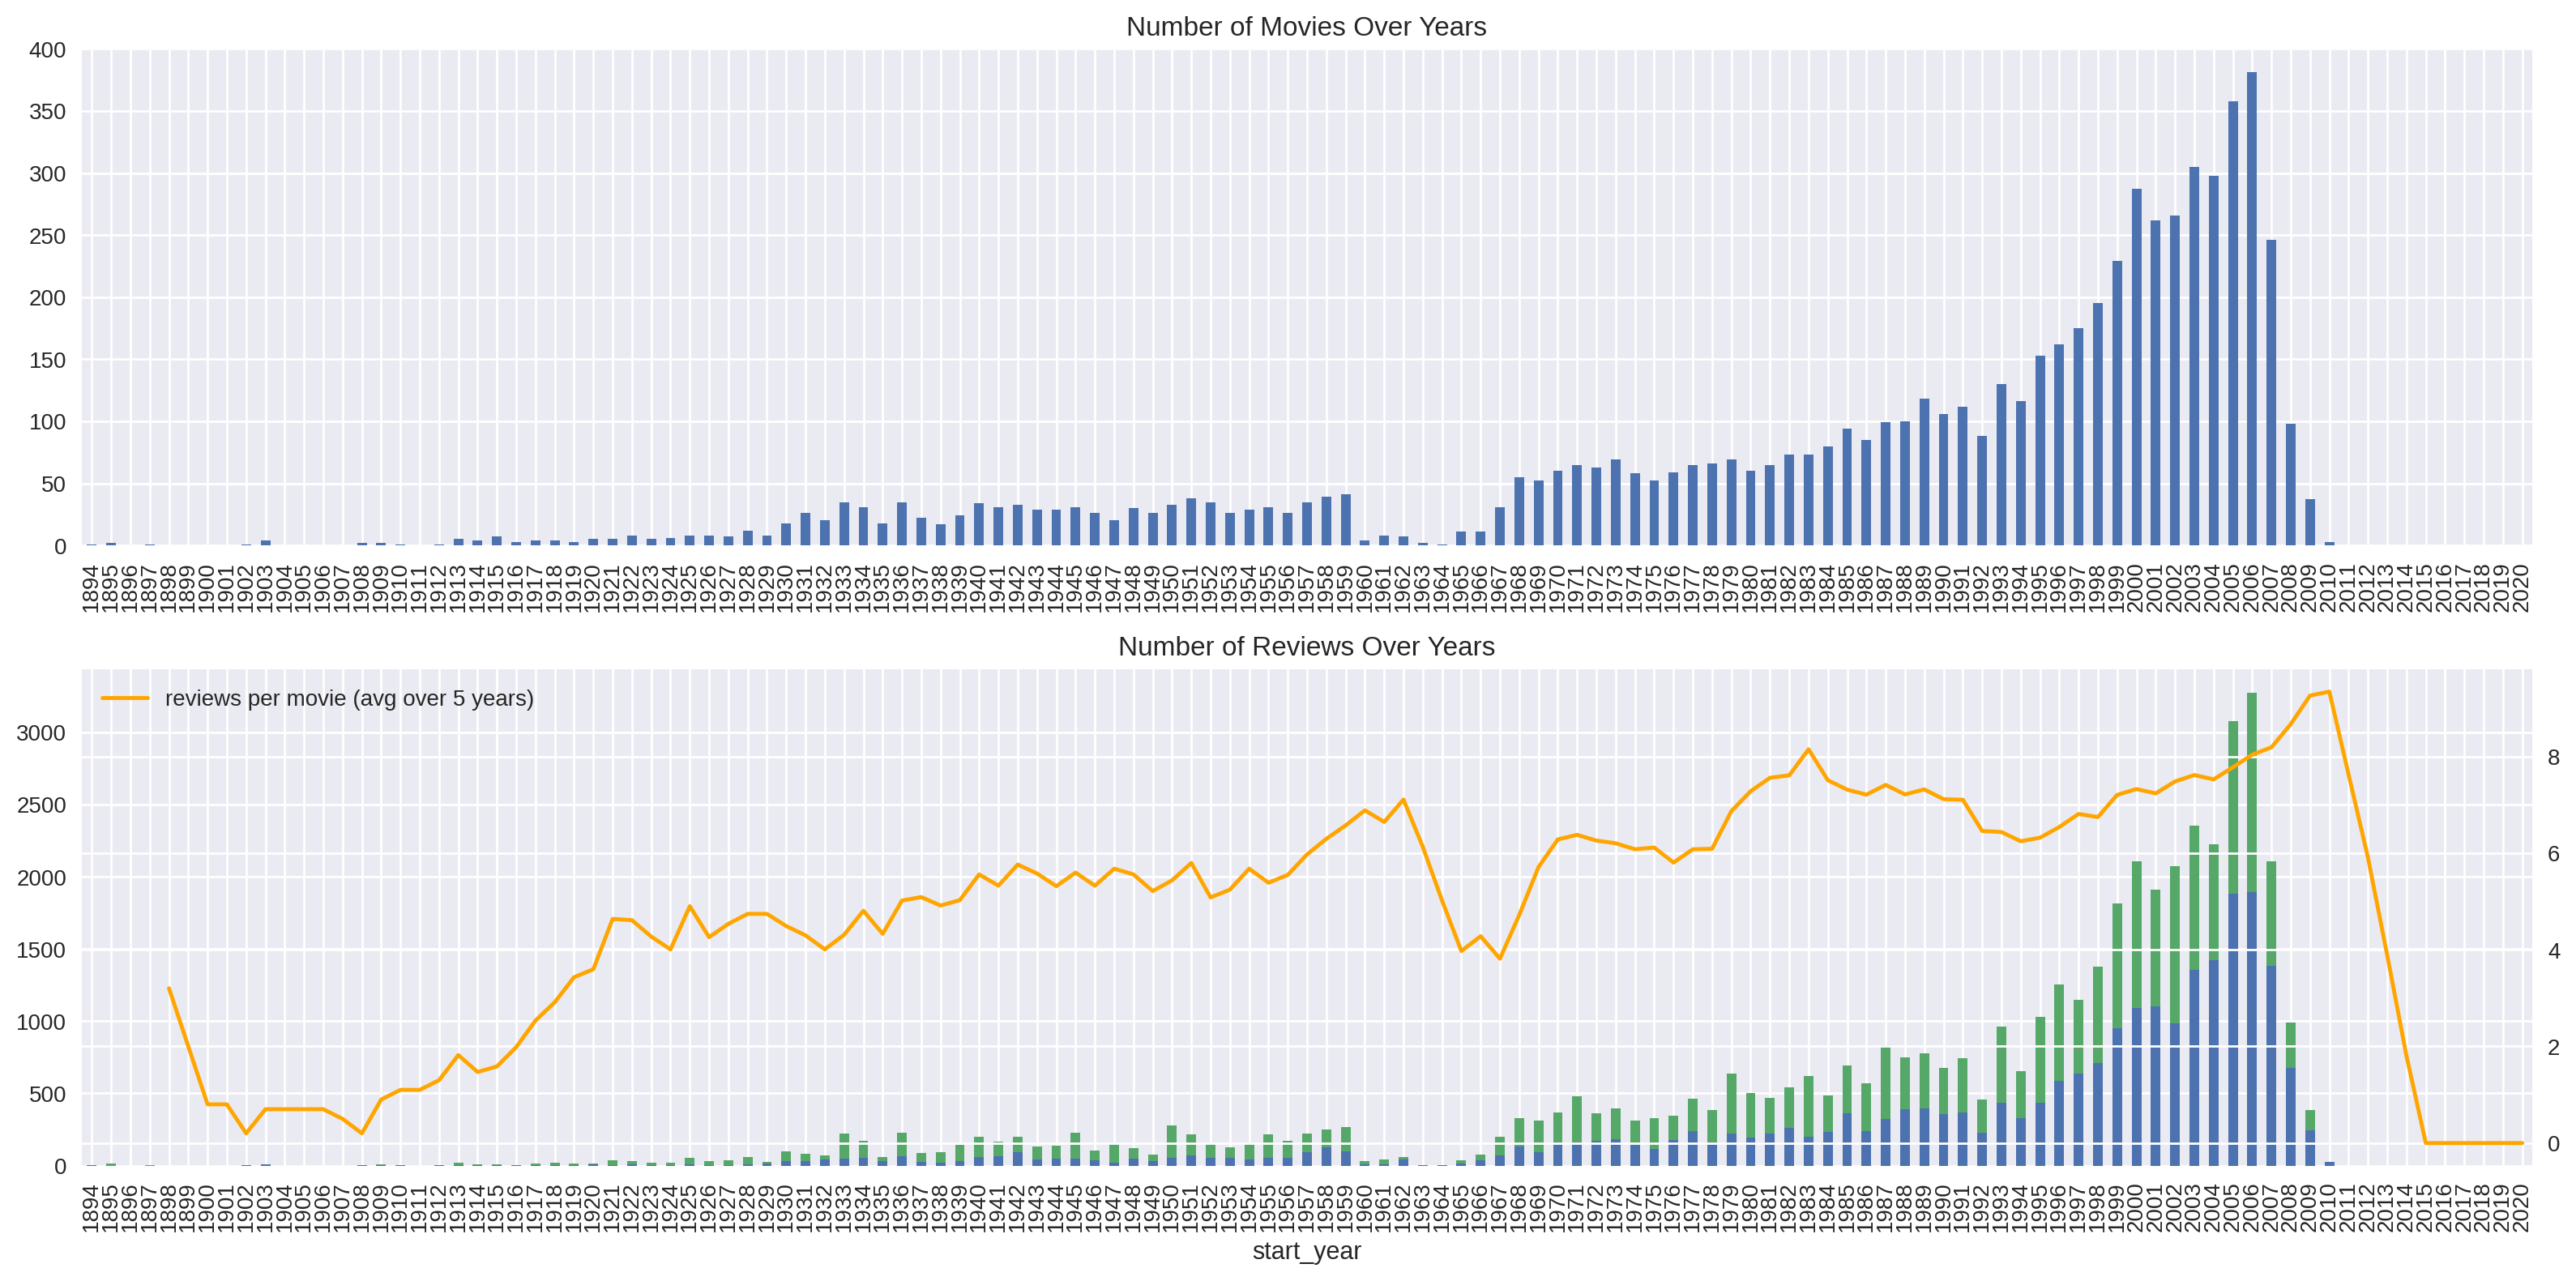

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

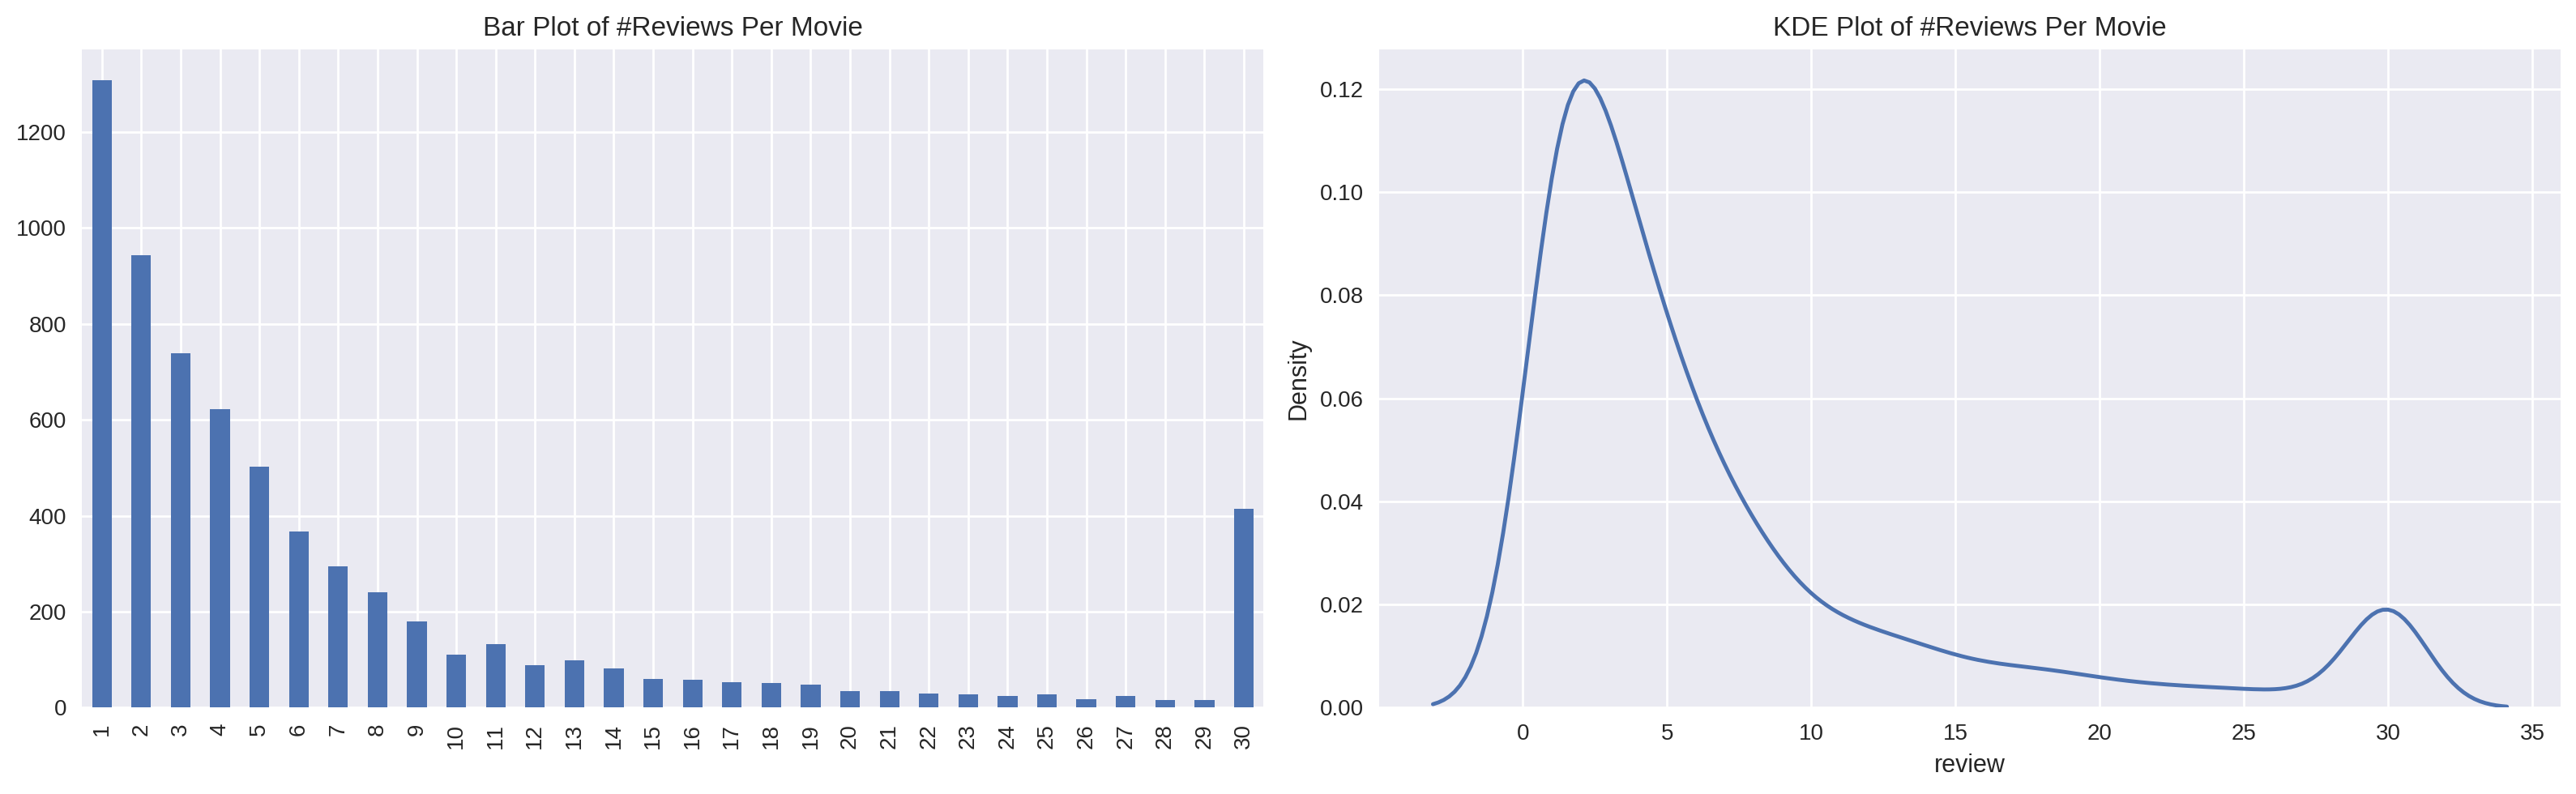

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [17]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501067
1    0.498933
Name: pos, dtype: float64

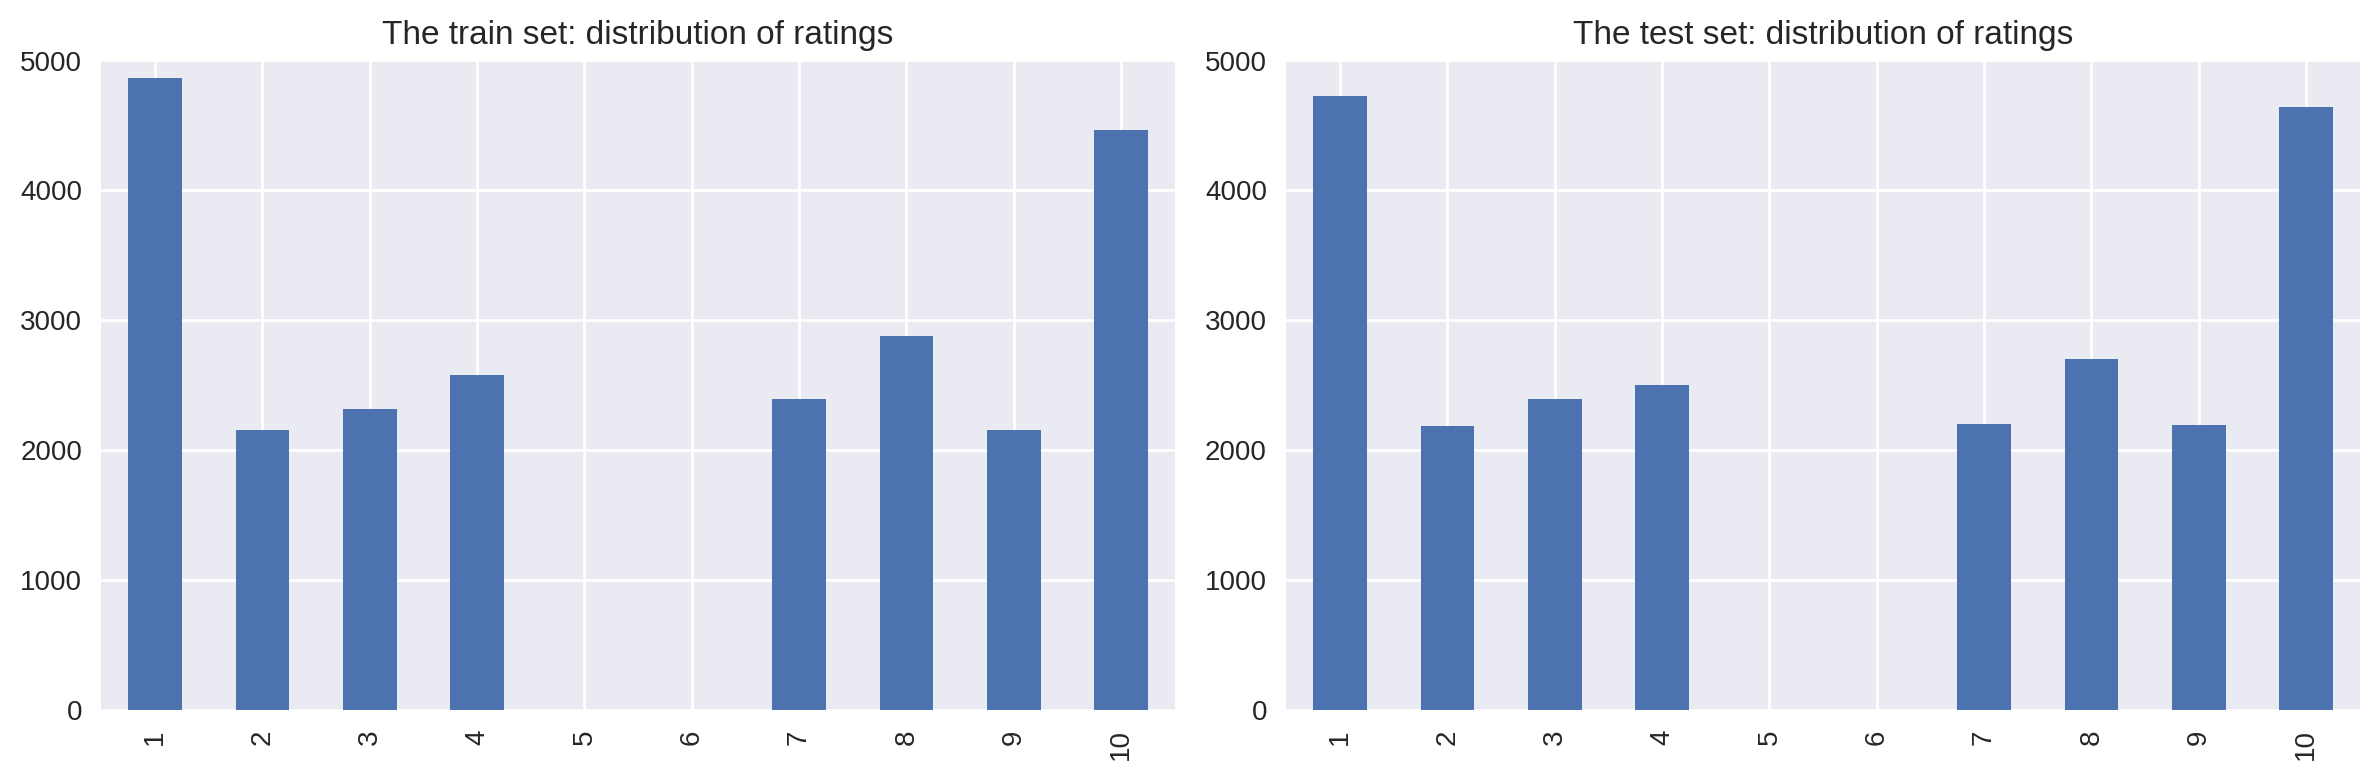

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


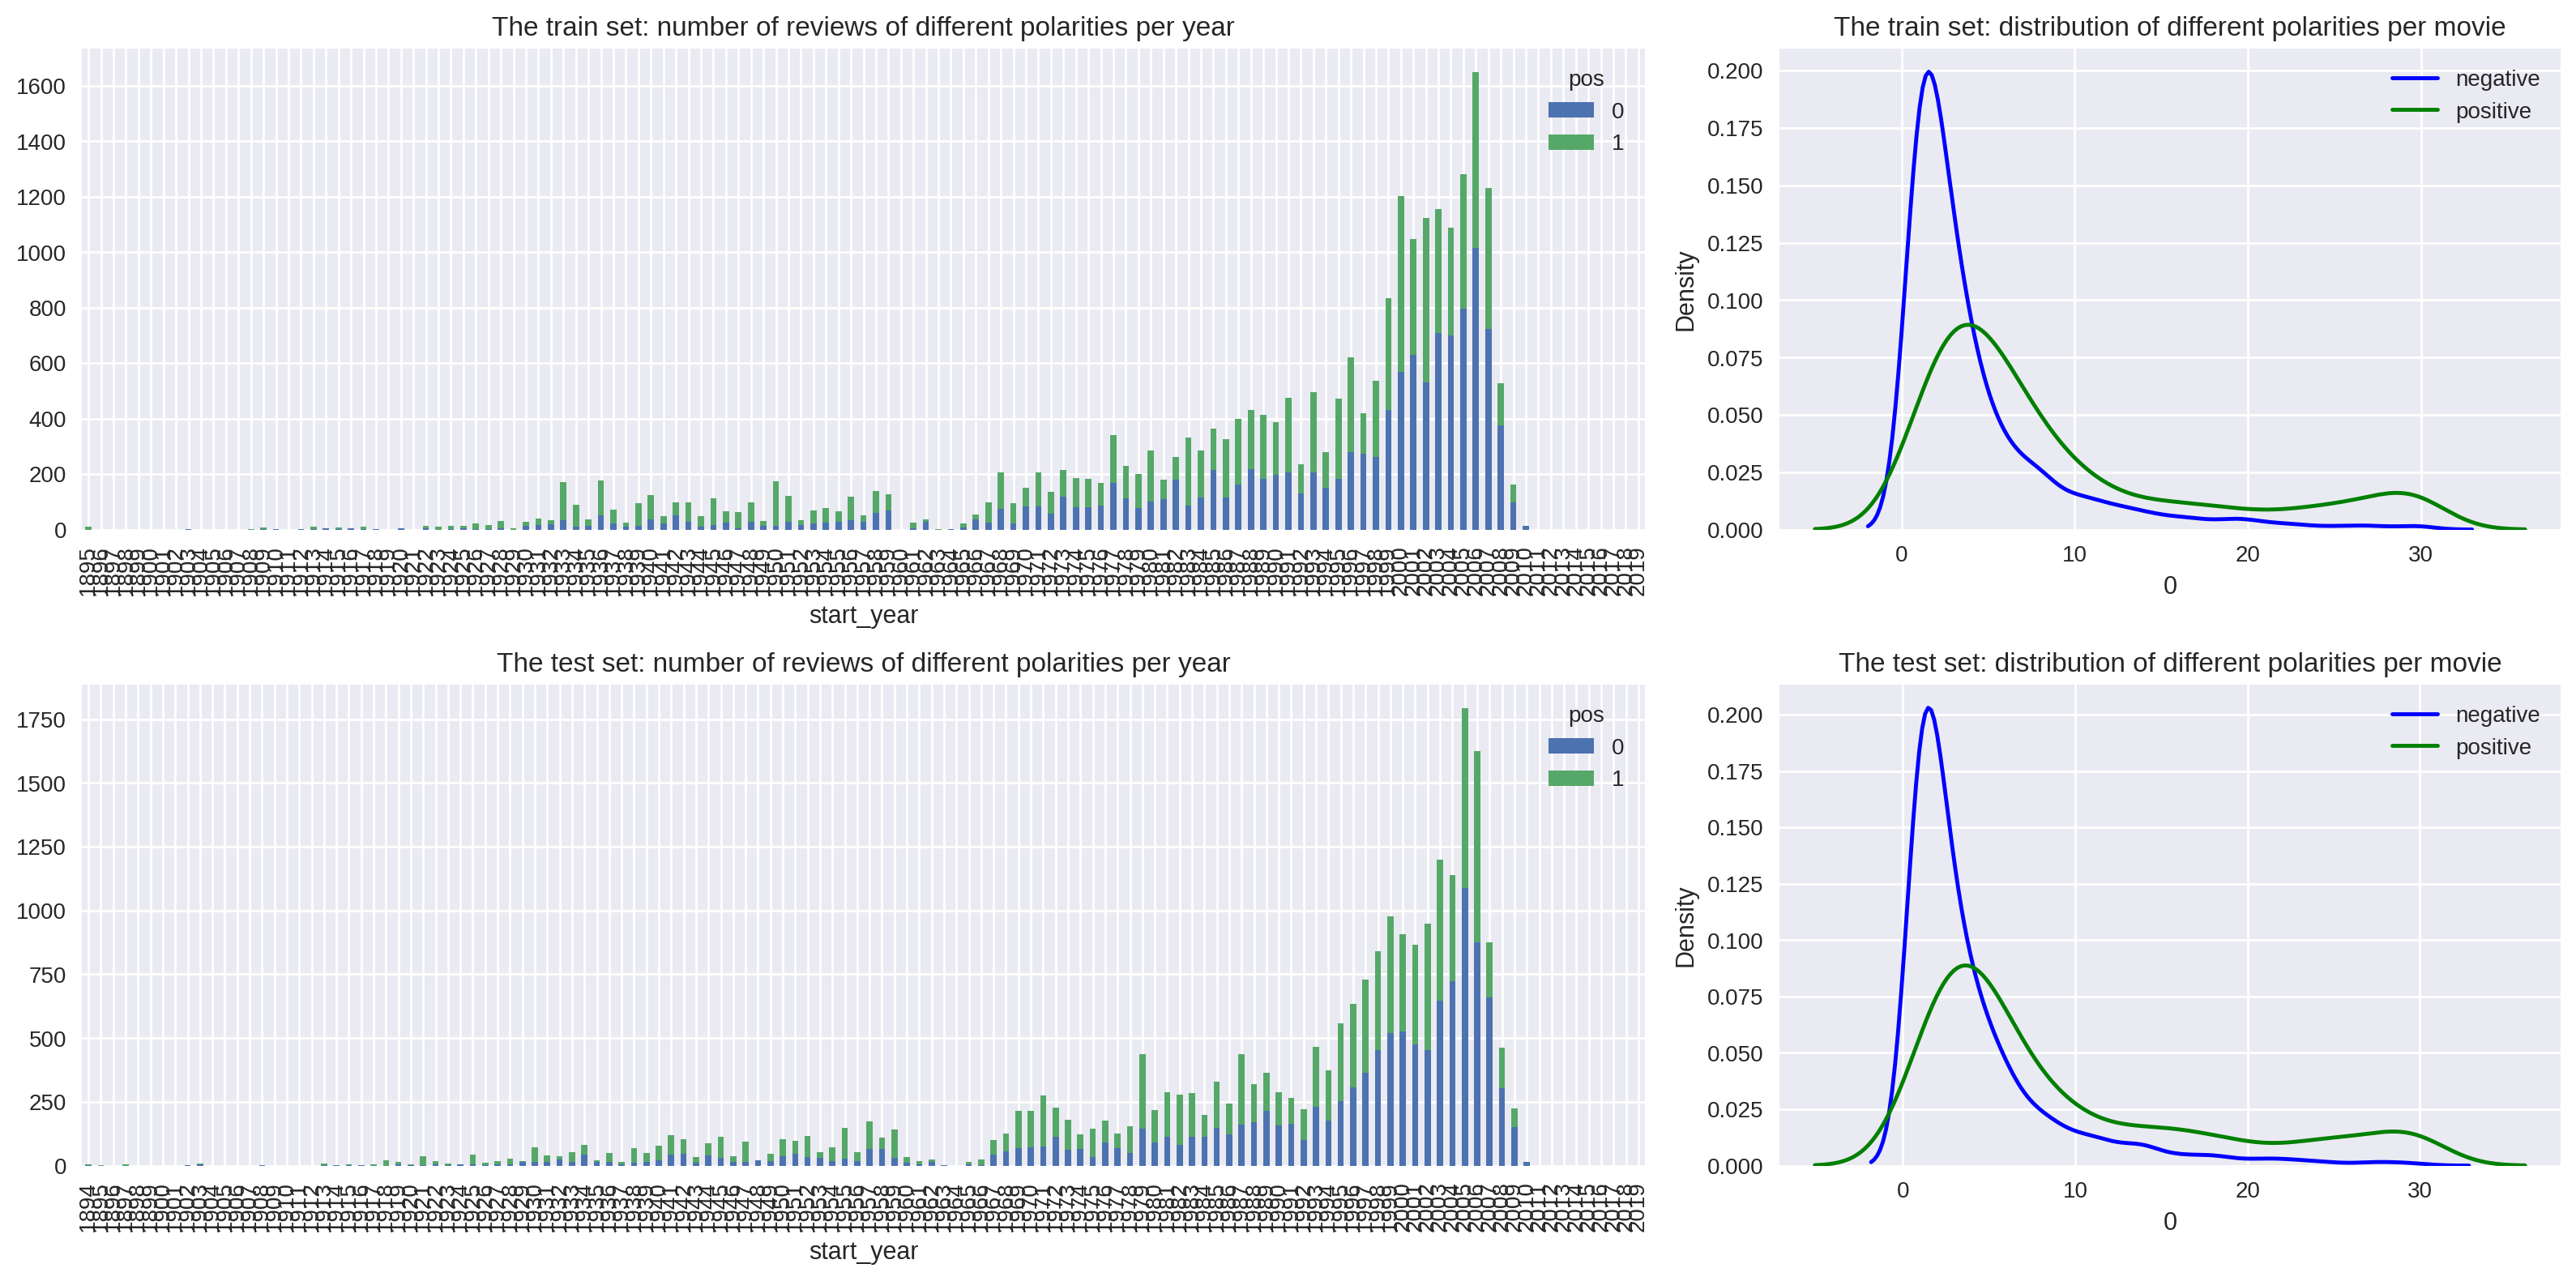

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The EDA demonstrates the varying distribution of the data fields over time as well as showing how the polarity of the reviews are distributed. It shows, for instance, how the number of movies and movie reviews peaked in the late 2000s. This EDA will help if we find our models imbalanced or if we want to work on subsections of the data.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [20]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [21]:
def structure_confusion_matrix(matrix):
    # This method structures a confusion_matrix instance so that it is easier read.
    print('Confusion matrixes for the model are below, first by percentage, then by instances.')
    display(pd.DataFrame(matrix, columns=['Predicted False', 'Predicted True'], index=['Is False', 'Is True']).div(matrix.sum(axis=1), axis=0))
    display(pd.DataFrame(matrix, columns=['Predicted False', 'Predicted True'], index=['Is False', 'Is True']))

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [22]:
def preprocess_text(text, pattern = r'[^a-zA-Z]'):
    import re
    # I made the preprocessing code a function since it will need to be executed repeatably below.
    return ' '.join(re.sub(pattern, ' ', text.lower()).split())

In [23]:
%%time

import re

pattern = r'[^a-zA-Z]' #Locates all patterns that comprise either a word or a space.

#Populates a new field with all text that fits the established pattern from 'review.'
df_reviews['review_norm'] = df_reviews['review'].apply(preprocess_text)


CPU times: user 2.27 s, sys: 0 ns, total: 2.27 s
Wall time: 2.29 s


In [24]:
df_reviews.sample(10)

,index,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
38071,38073,tt0734646,tvEpisode,The Hunt,The Hunt,1962,\N,25,0,"Drama,Fantasy,Horror",8.1,1795,"In this episode, a man and his dog go 'coon hu...",7,pos,1,test,3412,in this episode a man and his dog go coon hunt...
41829,41831,tt0218625,movie,The St. Francisville Experiment,The St. Francisville Experiment,2000,\N,79,0,"Horror,Mystery,Thriller",4.1,1464,I rented this one by accident. I lifted the vi...,1,neg,0,test,11800,i rented this one by accident i lifted the vid...
30297,30299,tt0215174,movie,Sex Files: Sexecutioner,Sex Files: Sexecutioner,1998,\N,88,1,Drama,5.2,57,A female executioner (played by the sexy Jenni...,10,pos,1,train,2224,a female executioner played by the sexy jennif...
26814,26816,tt0187844,tvEpisode,Premiere,Premiere,1999,\N,90,0,"Action,Adventure,Drama",8.0,3393,I think that FARSCAPE is the best scifi since ...,9,pos,1,test,5577,i think that farscape is the best scifi since ...
10827,10827,tt0099446,movie,Dr. Petiot,Docteur Petiot,1990,\N,102,0,"Biography,Crime,Drama",7.1,546,I discovered this film after reading the book ...,9,pos,1,train,3410,i discovered this film after reading the book ...
41151,41153,tt0265662,movie,The Rookie,The Rookie,2002,\N,127,0,"Drama,Family,Sport",6.9,31442,"Despite Disney's best efforts, this is a rathe...",8,pos,1,train,3619,despite disney s best efforts this is a rather...
23059,23061,tt0119723,movie,Mrs Dalloway,Mrs Dalloway,1997,\N,97,0,"Drama,Romance",6.6,3469,"I kept waiting for the film to move me, inspir...",3,neg,0,test,9803,i kept waiting for the film to move me inspire...
17844,17844,tt0373024,movie,Imaginary Heroes,Imaginary Heroes,2004,\N,111,0,"Comedy,Drama",7.2,9339,The somewhat-belligerent brother of a suicide ...,4,neg,0,test,1407,the somewhat belligerent brother of a suicide ...
11211,11211,tt0393597,movie,Earth,Earth,2007,\N,90,0,Documentary,8.0,14099,Rather annoying that reviewers keep comparing ...,10,pos,1,train,1424,rather annoying that reviewers keep comparing ...
30677,30679,tt0120117,movie,Shikari,Shikari,2000,\N,160,0,"Crime,Drama,Thriller",4.5,392,i am a big fan of karishma Kapoor and Govinda....,1,neg,0,train,6846,i am a big fan of karishma kapoor and govinda ...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

features_train = df_reviews_train['review_norm']
features_test = df_reviews_test['review_norm']

## Working with models

### Model 0 - Constant

In [26]:
from sklearn.dummy import DummyClassifier

F1 Score on Test Set: 0.6652865609846014
          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50
Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.0,1.0
Is True,0.0,1.0


,Predicted False,Predicted True
Is False,0,11803
Is True,0,11730


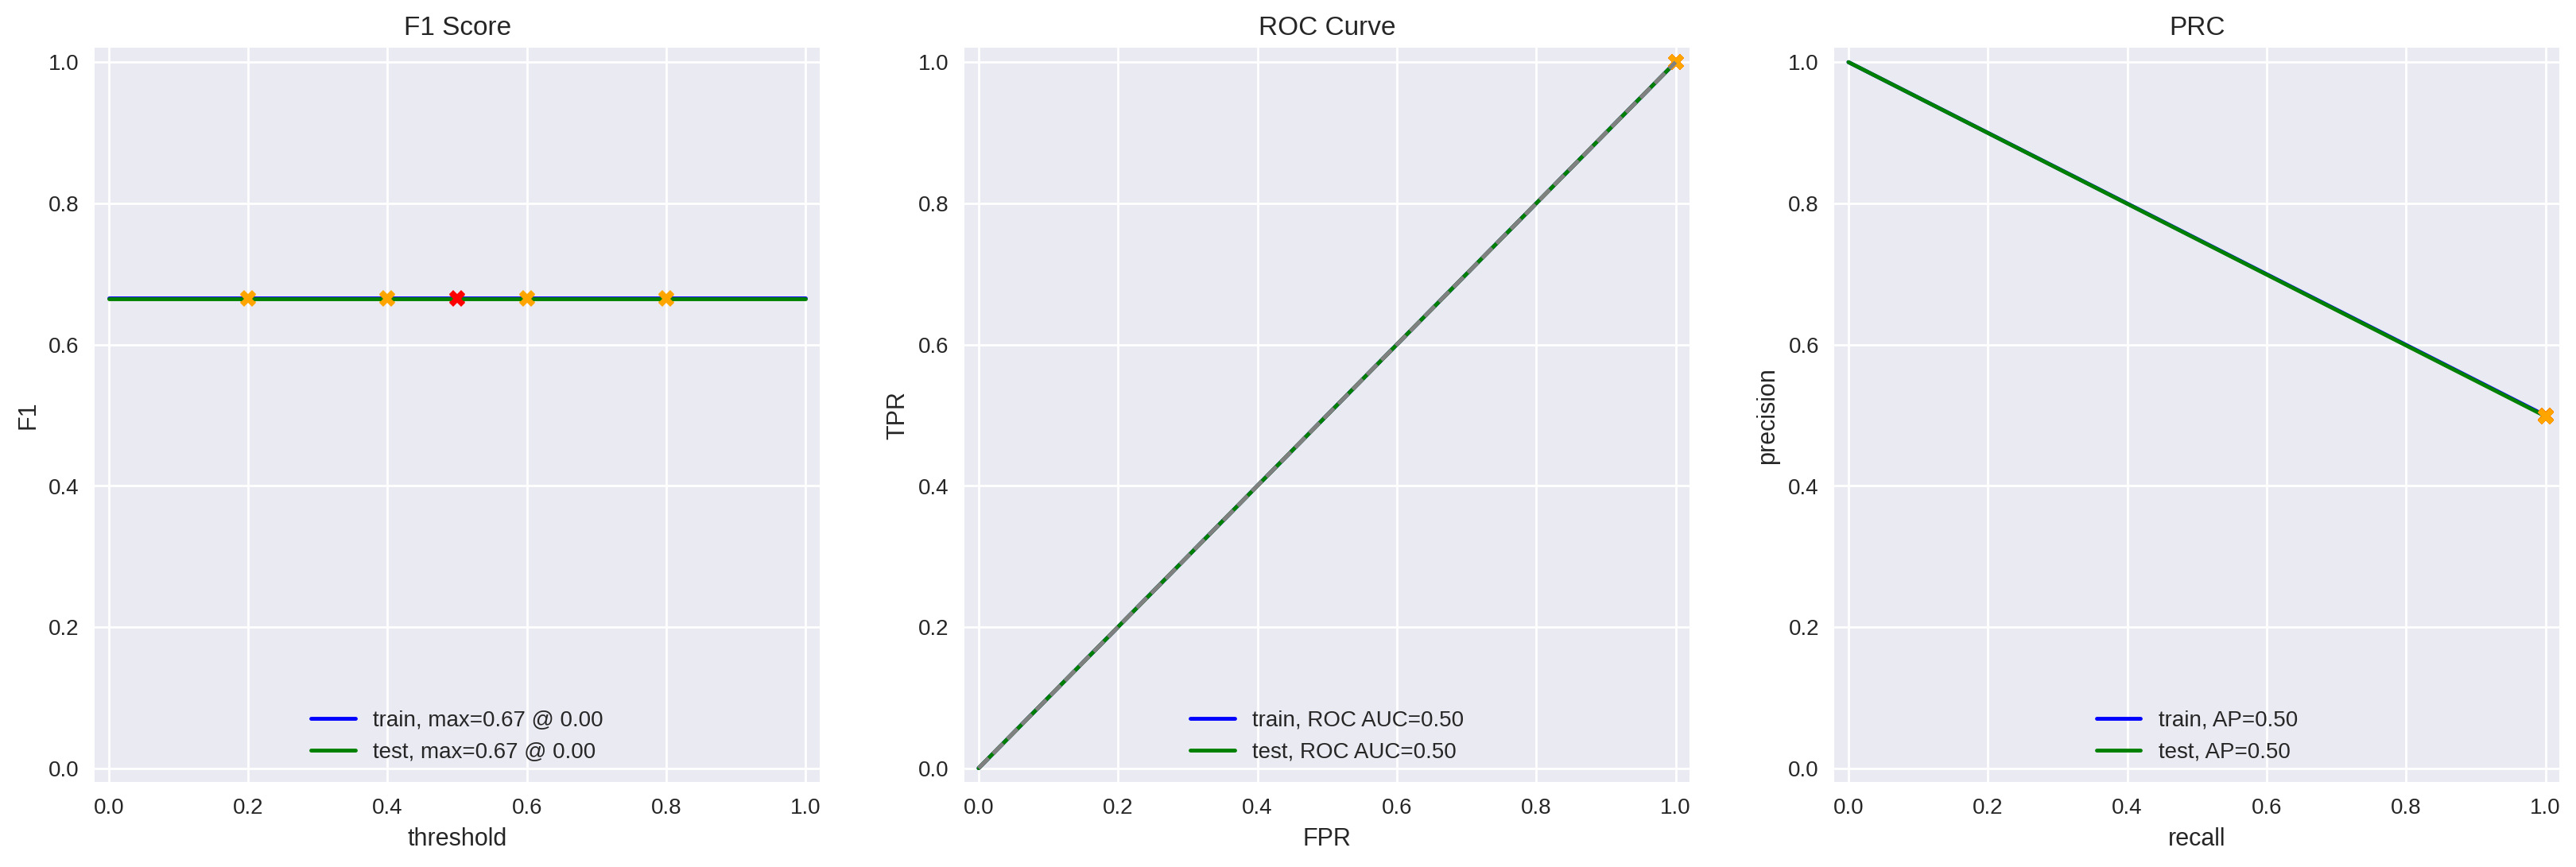

In [27]:
dummy = DummyClassifier(strategy='constant', constant=1, random_state=42)
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)
print('F1 Score on Test Set:', f1_score(target_test, predictions))

evaluate_model(dummy, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))


The baseline is an F1 score of .665. Every model needs to exceed that to be better than a constant choice of always picking 1.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [28]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline

In [29]:
df_reviews_train.head()

,index,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
7,7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,this true story of carlson s raiders is more o...
8,8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,should have been titled balderdash little in t...
9,9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,the movie gung ho the story of carlson s makin...


In [30]:
%%time

stop_words = set(stopwords.words('english'))
print(stop_words, '\n')
# import TfidfVectorizer
corpus = df_reviews['review_norm']

model_1 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1)),  # Convert text to TF-IDF features
    LogisticRegression(max_iter=1000)  # Logistic regression model
)

# Train the model
model_1.fit(features_train, target_train)

# Predict on the test data

predictions = model_1.predict(features_test)

print("F1 Score on Test Set:", f1_score(target_test, predictions))

{'i', 'after', 'having', 'between', 'while', 'if', 'those', 'but', 'down', 'itself', 'why', "it's", 'himself', "isn't", "wasn't", 'do', 'the', "aren't", 'more', 'not', 'again', 'ourselves', 'this', 'yourself', 'these', 'ma', 'we', 'few', 'shan', 'couldn', 're', "didn't", 'weren', 'you', 'some', 'have', 'y', 'by', "won't", 'me', 'where', 'don', 'should', 'any', 'hasn', 'won', 'wouldn', 'into', 'each', 'm', 'o', 'were', 'through', "that'll", "haven't", 'mightn', 'here', "mustn't", 'wasn', 'too', 'only', 'him', 'myself', 'herself', 'then', 'other', 'nor', 'yours', 'with', 'ours', 'over', 'who', 'than', 'a', 'on', 'yourselves', 'haven', 'off', "you'd", 'our', 'that', 'up', 'most', 'for', 'doesn', 'once', 'themselves', 'hadn', "wouldn't", "doesn't", 'about', 'he', "hadn't", 'his', 'is', 'doing', 'are', 'does', 'an', 'been', 'so', 'same', 'them', "mightn't", 'which', 'it', "don't", 'before', "you're", 's', 'be', 'further', 'because', 'out', 'her', 'd', 'ain', 'as', 'under', "couldn't", 'ther

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


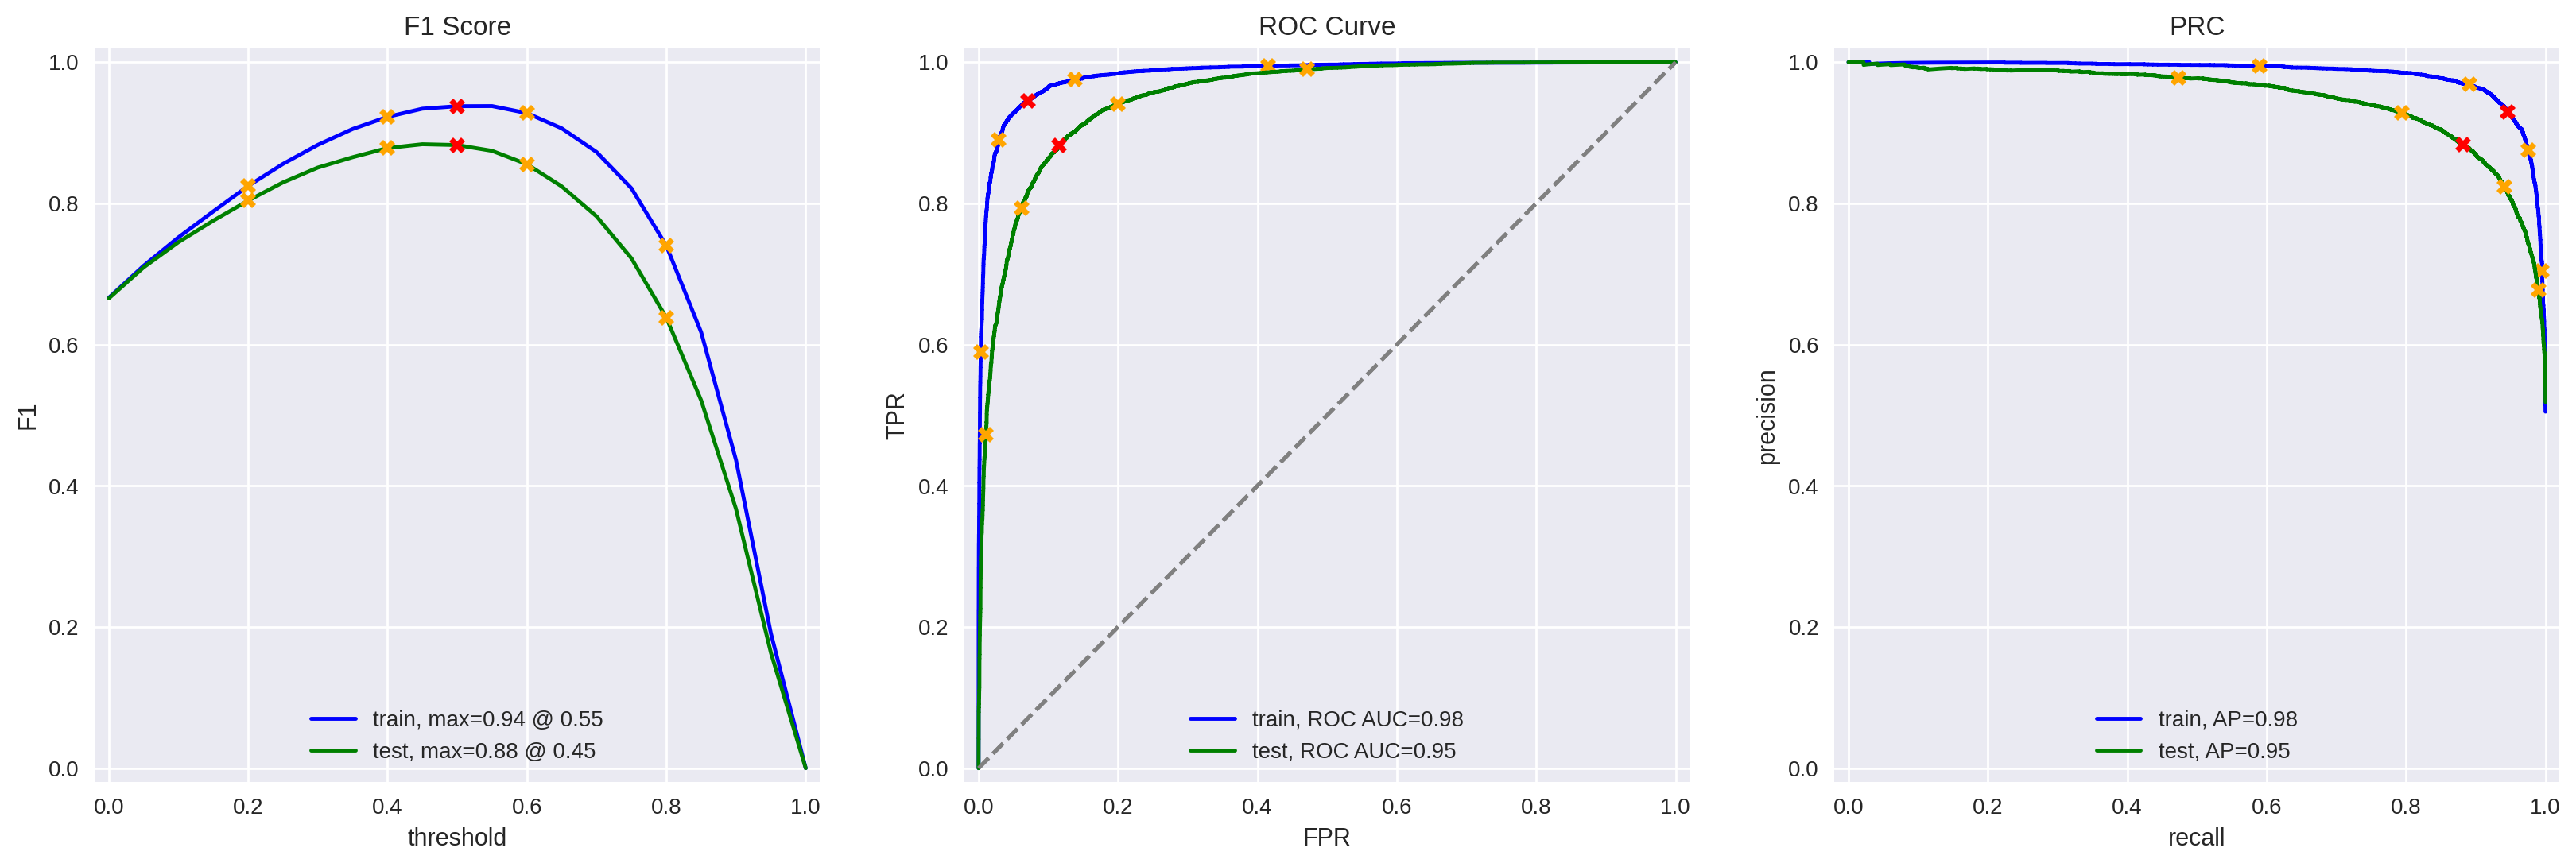

In [31]:
evaluate_model(model_1, features_train, target_train, features_test, target_test)

### Model 2 - TF-IDF, LogisticRegression, and Bigrams

F1 Score on Test Set: 0.8390843577787198
          train  test
Accuracy   0.99  0.84
F1         0.99  0.84
APS        1.00  0.91
ROC AUC    1.00  0.92
Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.833686,0.166314
Is True,0.156266,0.843734


,Predicted False,Predicted True
Is False,9840,1963
Is True,1833,9897


CPU times: user 34.2 s, sys: 8.68 s, total: 42.9 s
Wall time: 43.1 s


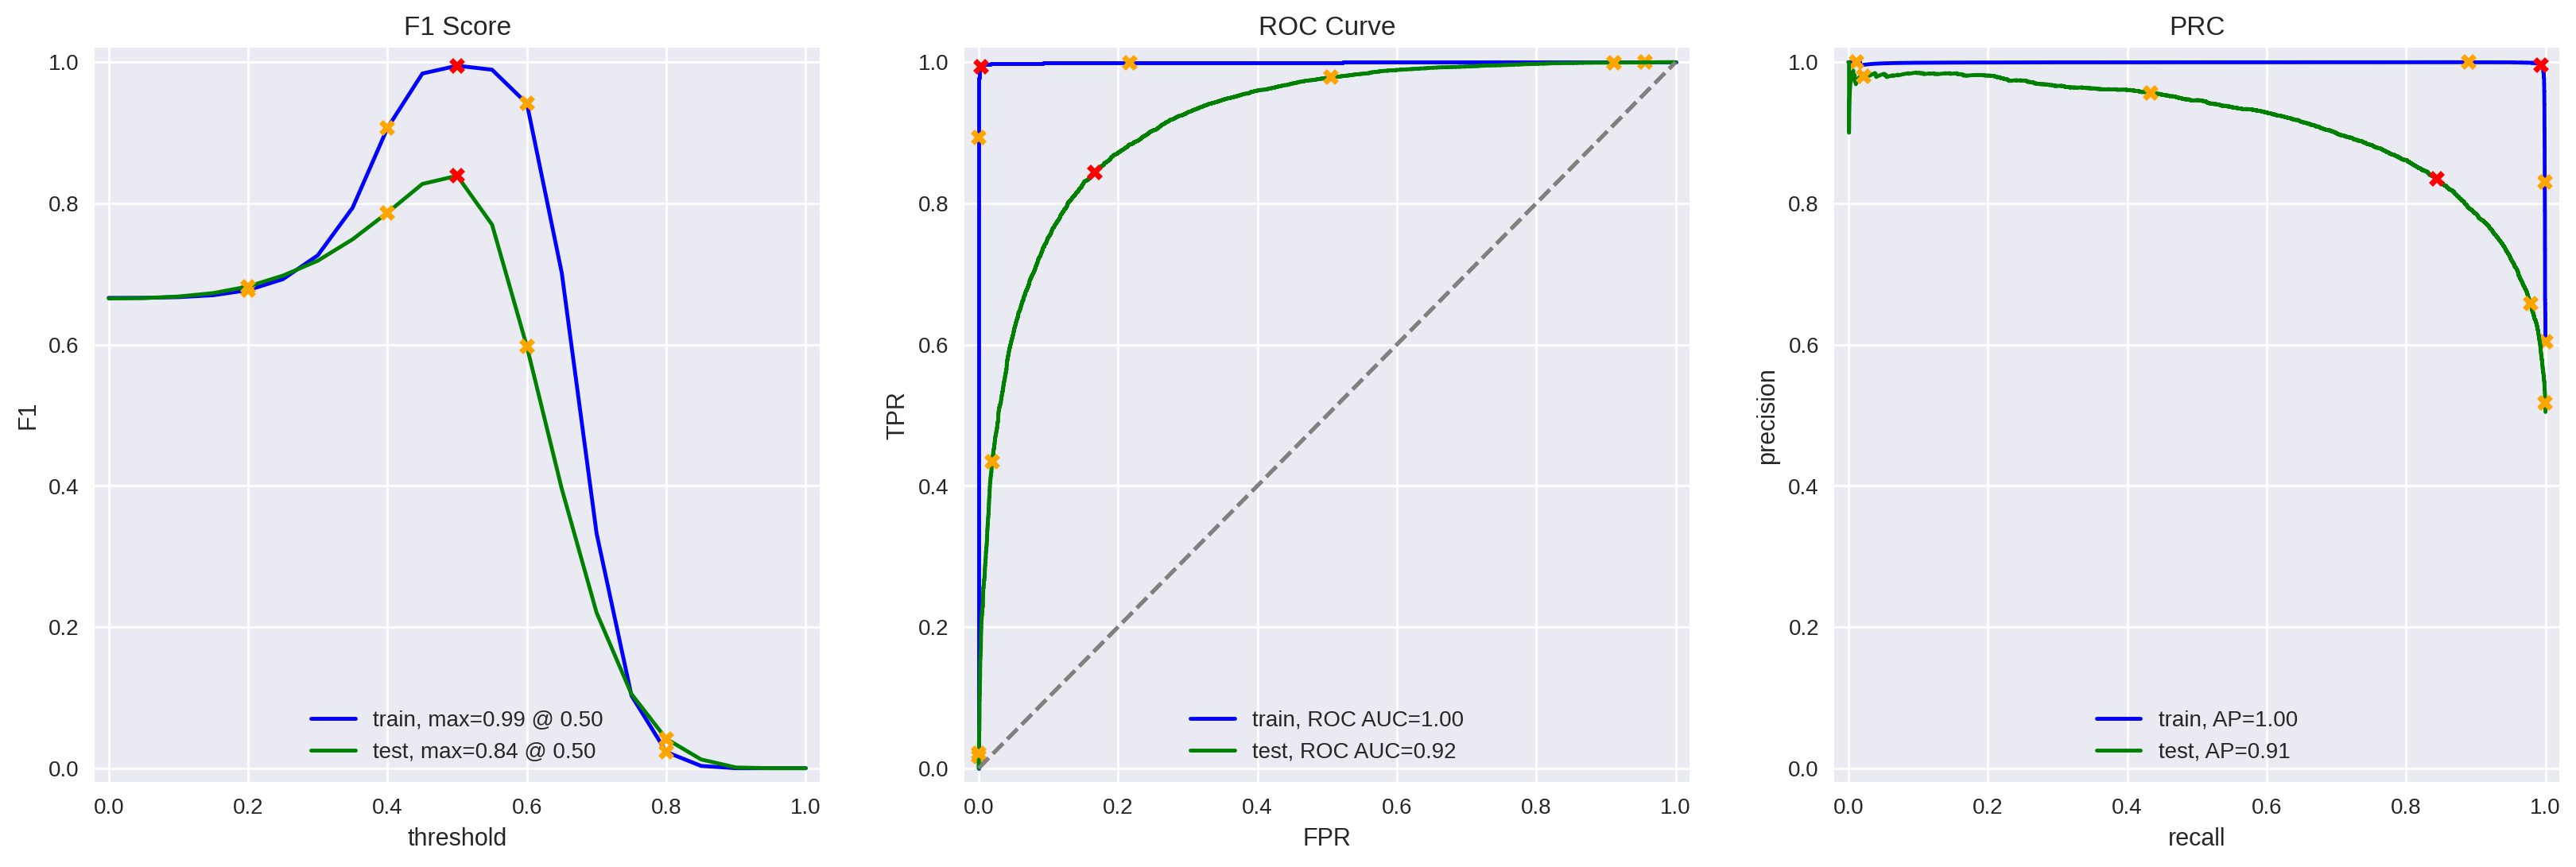

In [32]:
%%time

model_2 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2)),  # Convert text to TF-IDF features
    LogisticRegression(max_iter=1000)  # Logistic regression model
)

# Train the model
model_2.fit(features_train, target_train)

# Predict on the test data

predictions = model_2.predict(features_test)

print("F1 Score on Test Set:", f1_score(target_test, predictions))
evaluate_model(model_2, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct

</div>

### Model 3 - Bag of Words (BoW) and LogisticRegression

F1 Score on Test Set: 0.8595858039013491
          train  test
Accuracy    1.0  0.86
F1          1.0  0.86
APS         1.0  0.93
ROC AUC     1.0  0.93
Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.869440,0.130560
Is True,0.147229,0.852771


,Predicted False,Predicted True
Is False,10262,1541
Is True,1727,10003


CPU times: user 17.6 s, sys: 9.62 s, total: 27.2 s
Wall time: 27.2 s


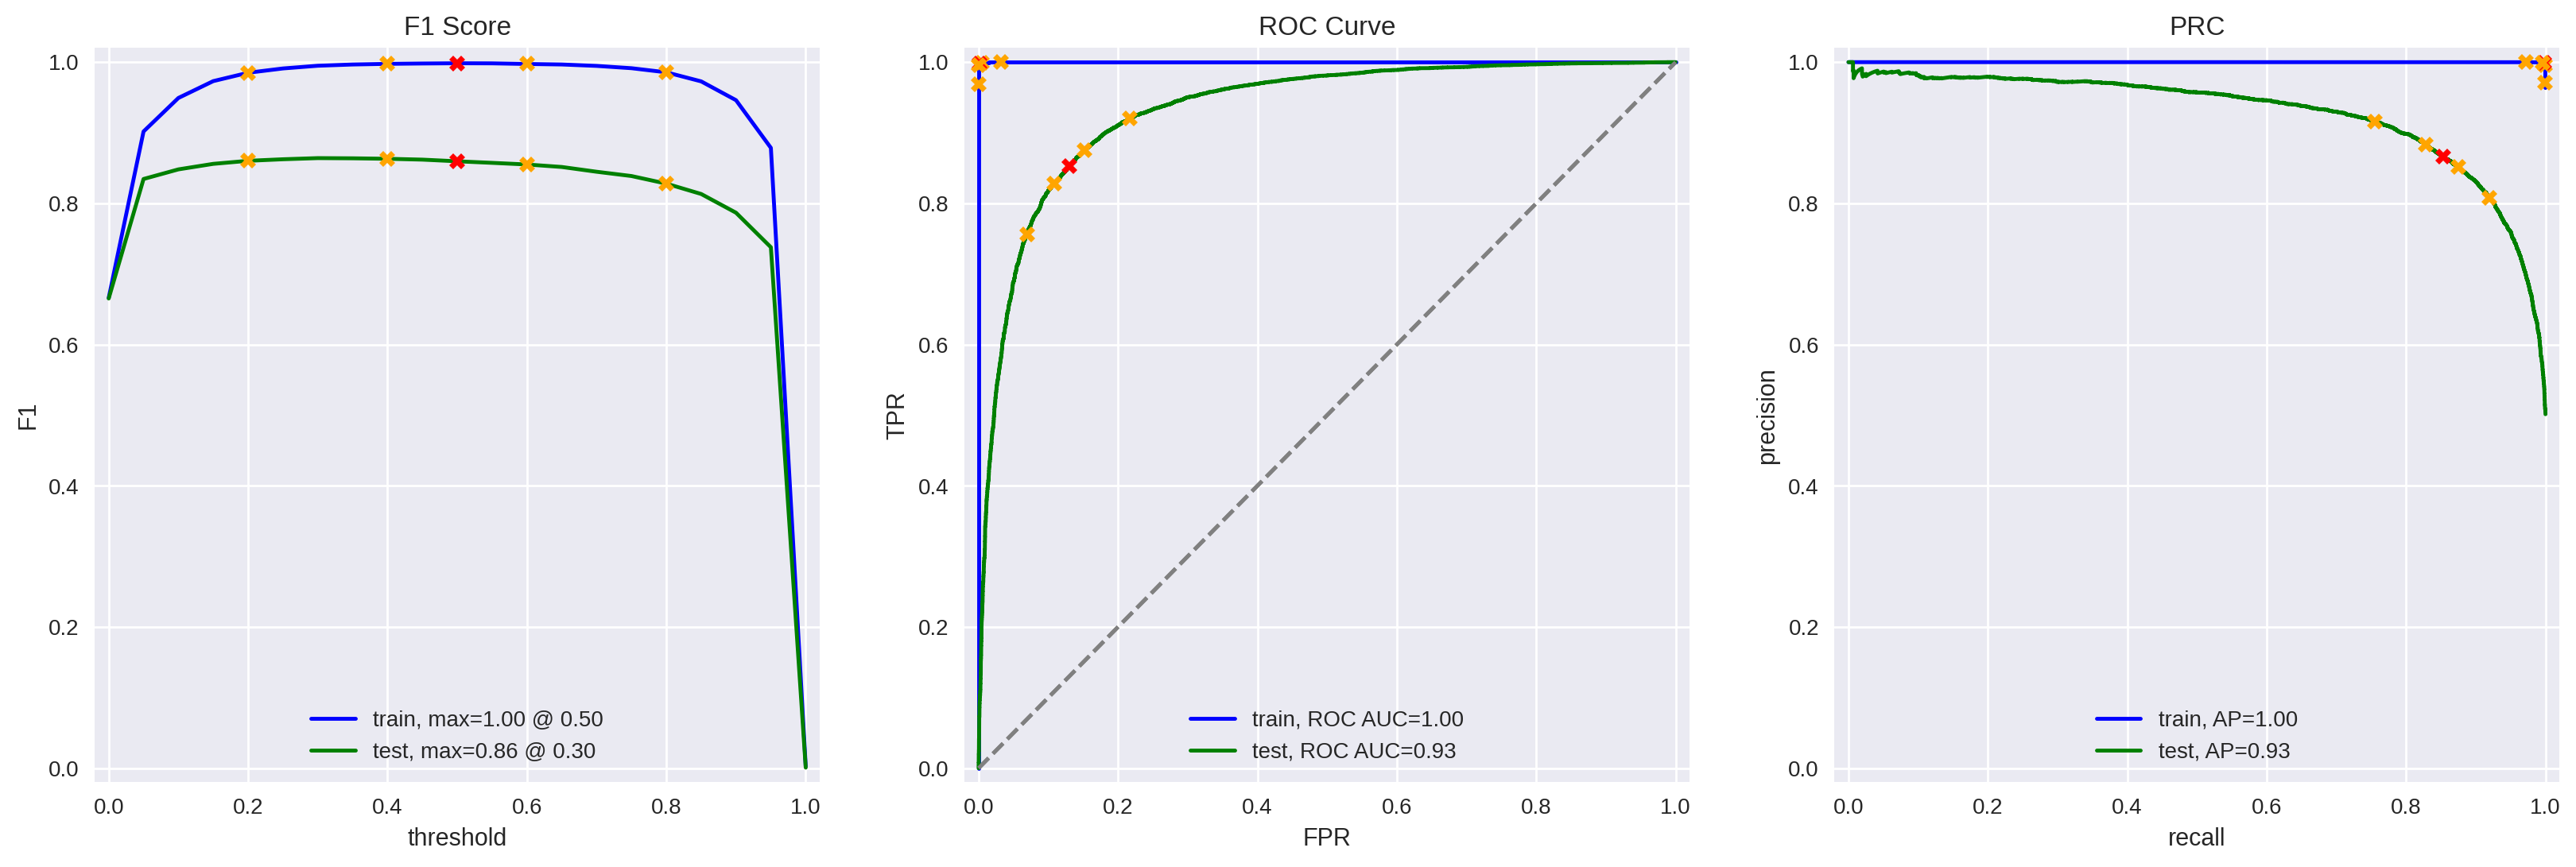

In [33]:
%%time 
from sklearn.feature_extraction.text import CountVectorizer

# create an n-gram with n=1 and store it in the n_gram variable

model_3 = make_pipeline(
    CountVectorizer(ngram_range=(1, 1), stop_words=stop_words),  # Convert text to BoW model
    LogisticRegression(max_iter=1000)  # Logistic regression model
)

# Train the model
model_3.fit(features_train, target_train)

# Predict on the test data

predictions = model_3.predict(features_test)

print("F1 Score on Test Set:", f1_score(target_test, predictions))
evaluate_model(model_3, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### Model 4 - spaCy, TF-IDF and LR

In [34]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    return ' '.join(tokens)

F1 Score on Test Set: 0.8746435108330141
          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95
Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.873846,0.126154
Is True,0.124126,0.875874


,Predicted False,Predicted True
Is False,10314,1489
Is True,1456,10274


CPU times: user 14min 50s, sys: 4.88 s, total: 14min 55s
Wall time: 14min 57s


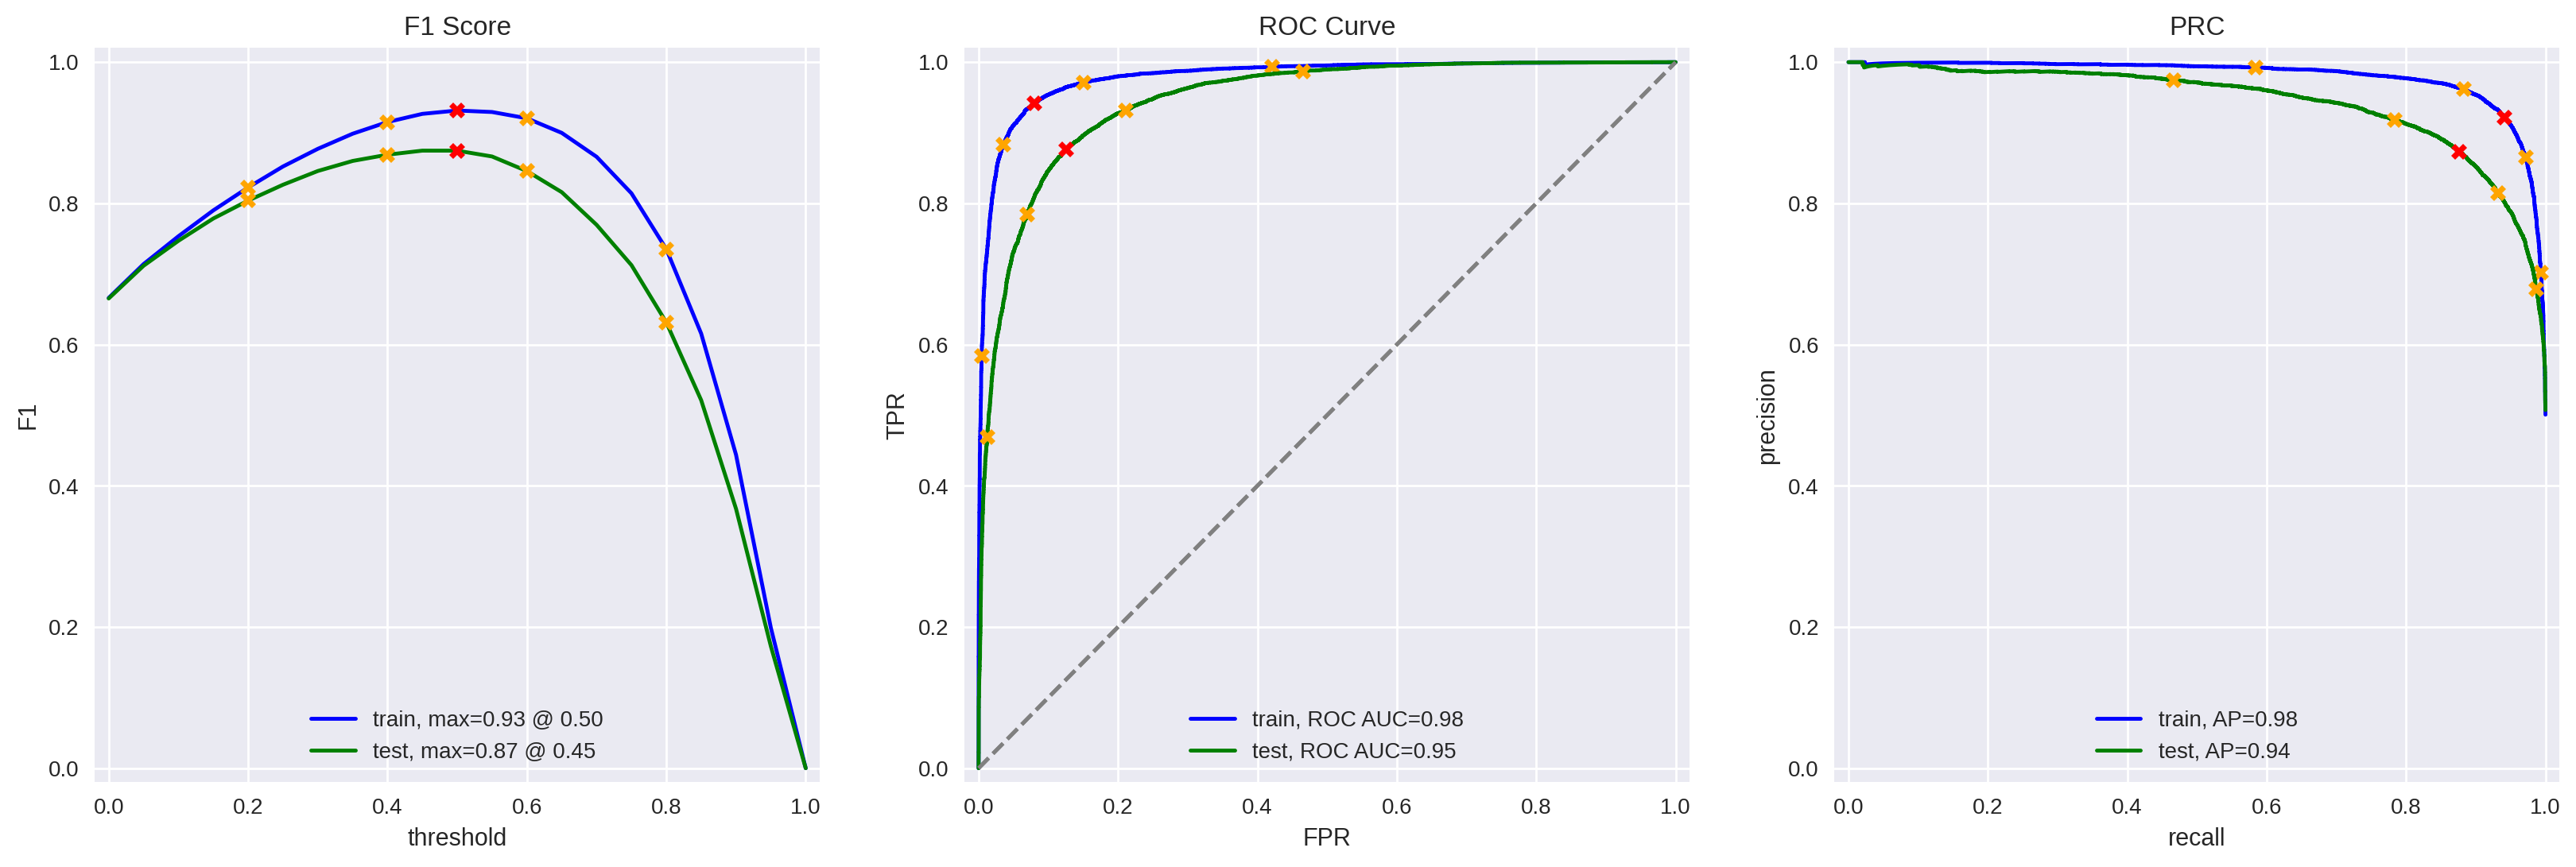

In [36]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords

# Populates a new field with all text that fits the established pattern from 'review.'
df_reviews['review_norm_lemma'] = df_reviews['review'].apply(text_preprocessing_3)

stop_words = set(nltk_stopwords.words('english'))

features_train = features_train.apply(text_preprocessing_3)
features_test = features_test.apply(text_preprocessing_3)

model_4 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1)),
    LogisticRegression(max_iter=1000)
)

# Train the model
model_4.fit(features_train, target_train)

# Predict on the test data

predictions = model_4.predict(features_test)

print("F1 Score on Test Set:", f1_score(target_test, predictions))
evaluate_model(model_4, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### Model 5 - spaCy, TF-IDF and LGBMClassifier

F1 Score on Test Set: 0.853354727019381
          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93
Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.843430,0.156570
Is True,0.138534,0.861466


,Predicted False,Predicted True
Is False,9955,1848
Is True,1625,10105


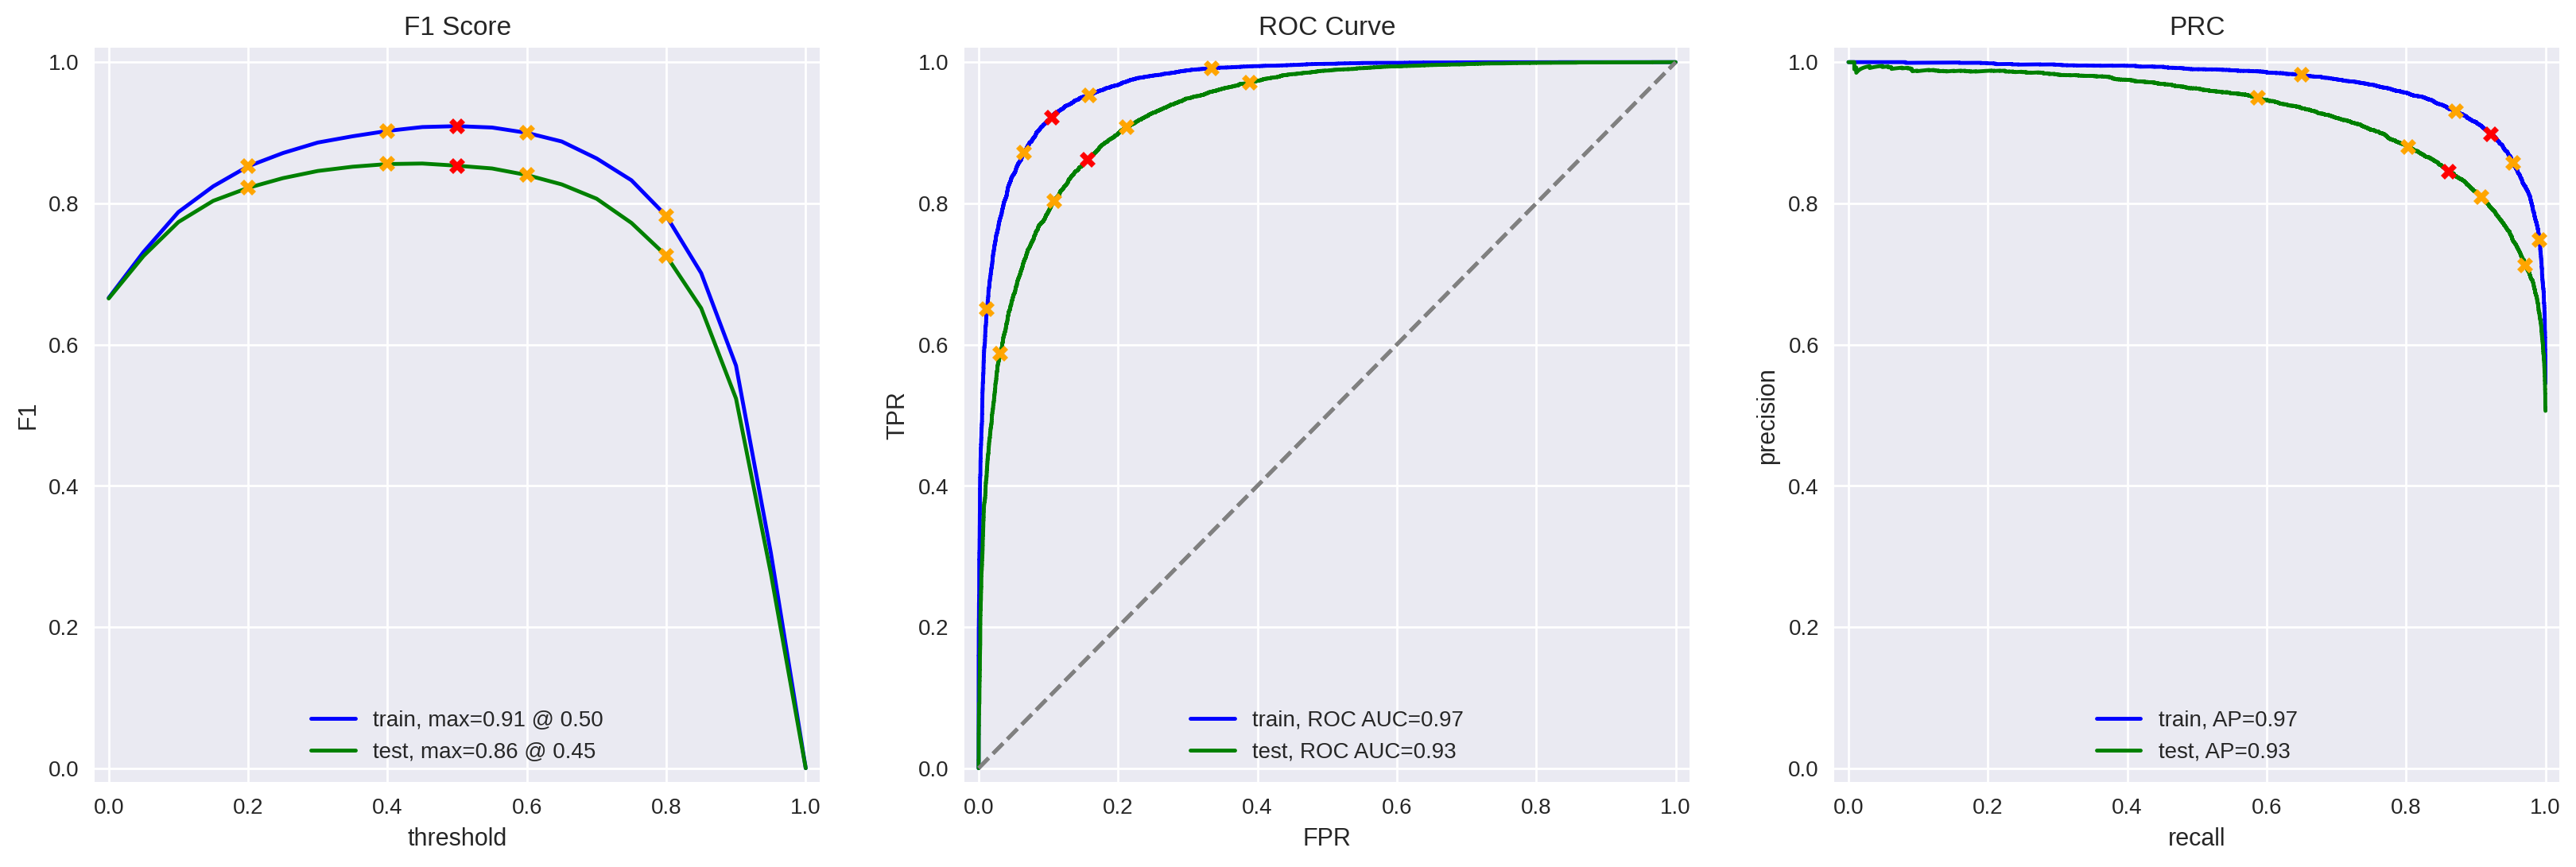

In [37]:
from lightgbm import LGBMClassifier

model_5 = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1), stop_words=stop_words),  # Convert text to TF-IDF model
    LGBMClassifier(boosting_type='gbdt')  # LGBMClassifier model
)

# Train the model
model_5.fit(features_train, target_train)

# Predict on the test data
predictions = model_5.predict(features_test)

print("F1 Score on Test Set:", f1_score(target_test, predictions))
evaluate_model(model_5, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### Model 6 - TF-IDF and CatBoostClassifier

F1 Score on Test Set: 0.842192006592501
          train  test
Accuracy   0.85  0.84
F1         0.86  0.84
APS        0.93  0.92
ROC AUC    0.93  0.92
Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.80344,0.19656
Is True,0.12873,0.87127


,Predicted False,Predicted True
Is False,9483,2320
Is True,1510,10220


CPU times: user 1min 31s, sys: 368 ms, total: 1min 32s
Wall time: 1min 32s


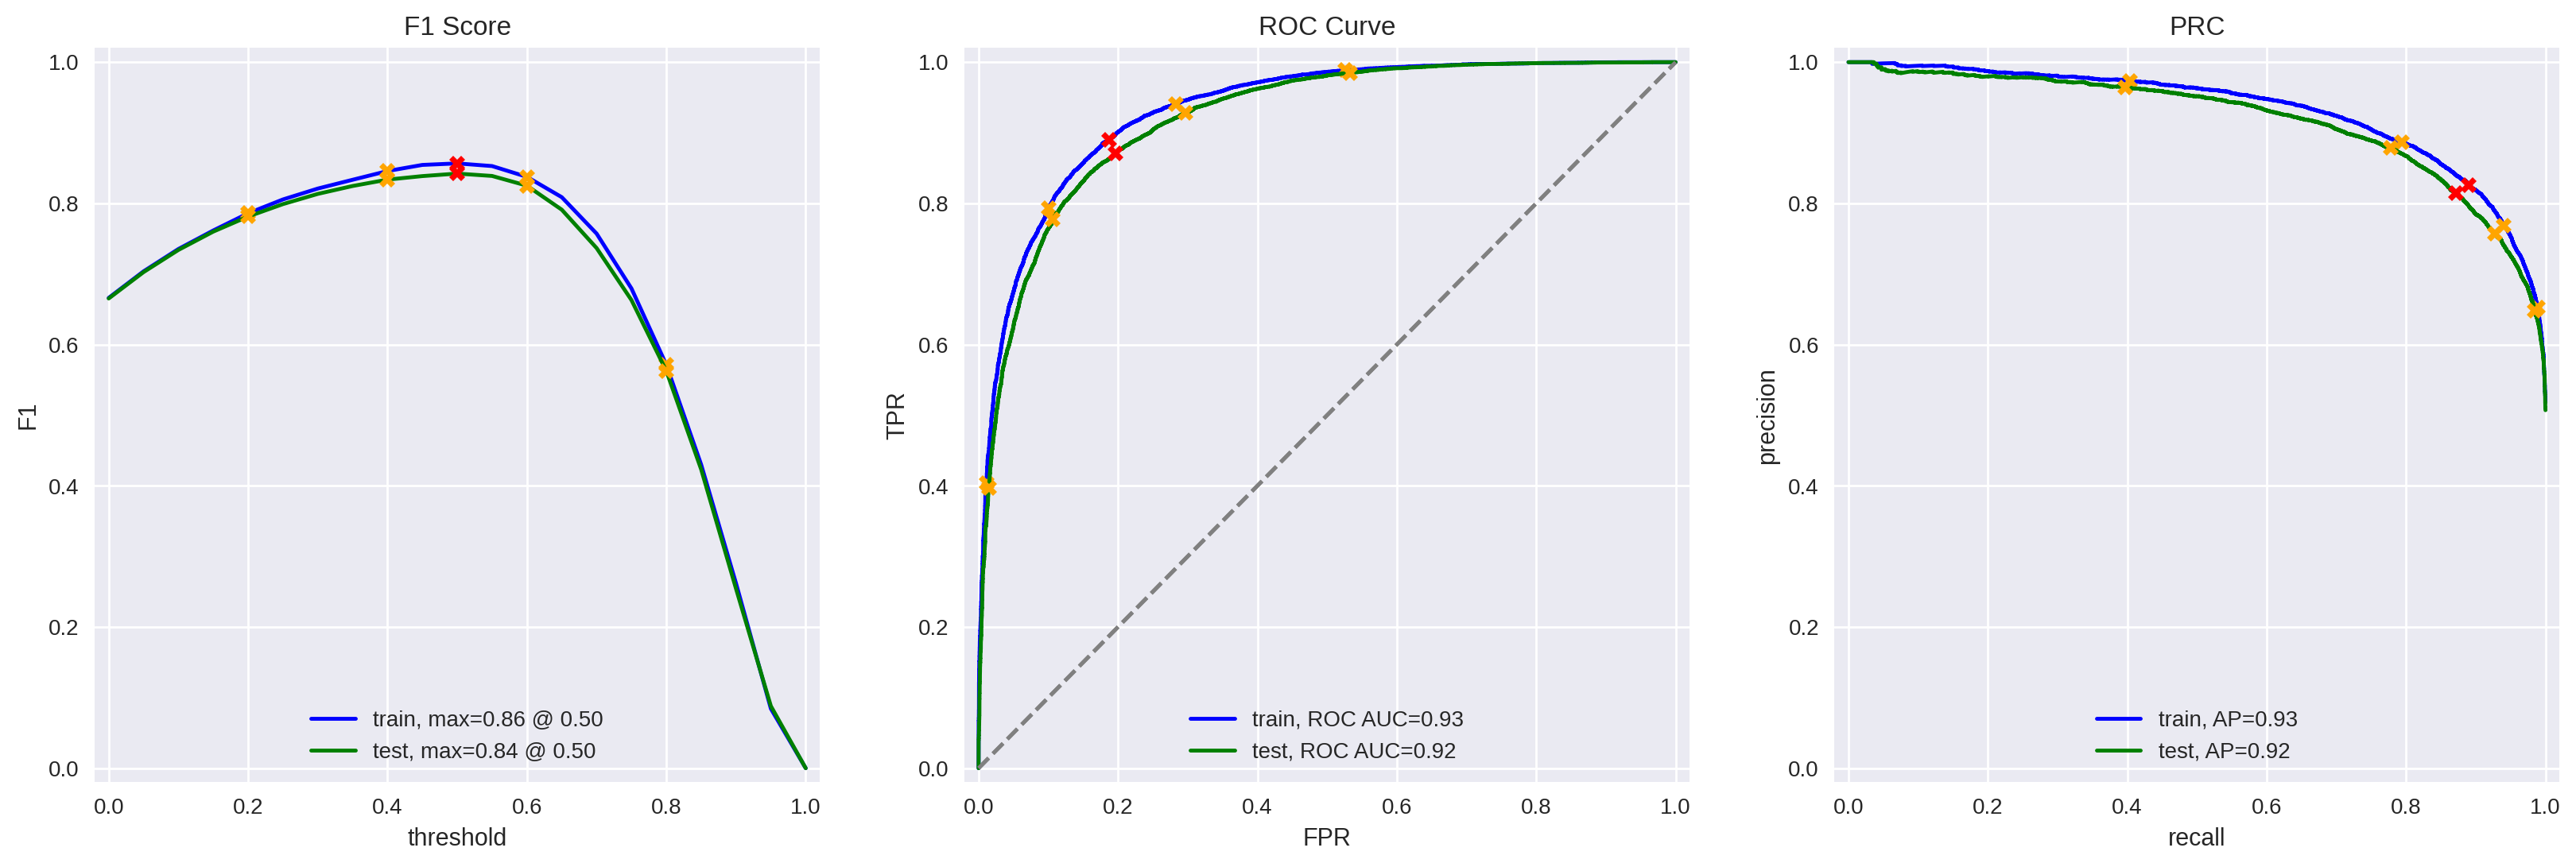

In [38]:
%%time

from catboost import CatBoostClassifier

model_6 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1)),
    CatBoostClassifier(
        iterations=250, 
        learning_rate=0.1,
        depth=3, 
        eval_metric='F1',
        random_seed=42,
        verbose=0,
        early_stopping_rounds=100
    )
)

# Train the model
model_6.fit(features_train, target_train)

# Predict on the test data

predictions = model_6.predict(features_test)

print("F1 Score on Test Set:", f1_score(target_test, predictions))
evaluate_model(model_6, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

## My Reviews

In [39]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['pos'] = pd.Series([0, 0, 1, 0, 1, 1, 0, 1])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: ' '.join(re.sub(pattern, ' ',  x.lower()).split()))

my_reviews

,review,pos,review_norm
0,"I did not simply like it, not my kind of movie.",0,i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",0,well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,1,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,1,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",1,the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,0,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,1,launching on netflix was a brave move i really...


### Model 1

In [40]:
texts = my_reviews['review_norm']
texts = texts.apply(preprocess_text)


my_reviews_pred_prob_1 = model_1.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_1[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 2

In [41]:
texts = my_reviews['review_norm']
texts = texts.apply(preprocess_text)

my_reviews_pred_prob_2 = model_2.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')

0.41:  i did not simply like it not my kind of movie
0.46:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.42:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didn t expect the reboot to be so good writers really cared about the source material
0.45:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.49:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.57:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [42]:
texts = my_reviews['review_norm']
texts = texts.apply(preprocess_text)


my_reviews_pred_prob_3 = model_3.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.39:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn t expect the reboot to be so good writers really cared about the source material
0.59:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_4 = model_4.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn t expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 5

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_5 = model_5.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_5[i]:.2f}:  {review}')

0.54:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.39:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.61:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.27:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.76:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 6

In [45]:
import sklearn.metrics as metrics

texts = my_reviews['review_norm']

my_reviews_pred_prob_6 = model_6.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_6[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.52:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.52:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.66:  i didn t expect the reboot to be so good writers really cared about the source material
0.55:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.41:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.65:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

In [46]:
results_df = pd.DataFrame(columns=['model', 'score_on_my_reviews'])

# List to hold the rows
rows = []

for i in range(1, 7):
    # Access model dynamically using eval or other method (assuming model_i variables exist)
    model = globals().get(f'model_{i}')
    
    if model is not None:
        # Predict and calculate the F1 score
        predictions = model.predict(texts)
        score = f1_score(my_reviews['pos'], predictions)
        
        # Append result to the rows list
        rows.append({'model': f'model_{i}', 'score_on_my_reviews': score})

# Convert the list of rows to a DataFrame
results_df = pd.DataFrame(rows)

print(results_df)

     model  score_on_my_reviews
0  model_1             0.666667
1  model_2             0.666667
2  model_3             0.857143
3  model_4             0.666667
4  model_5             0.800000
5  model_6             0.800000


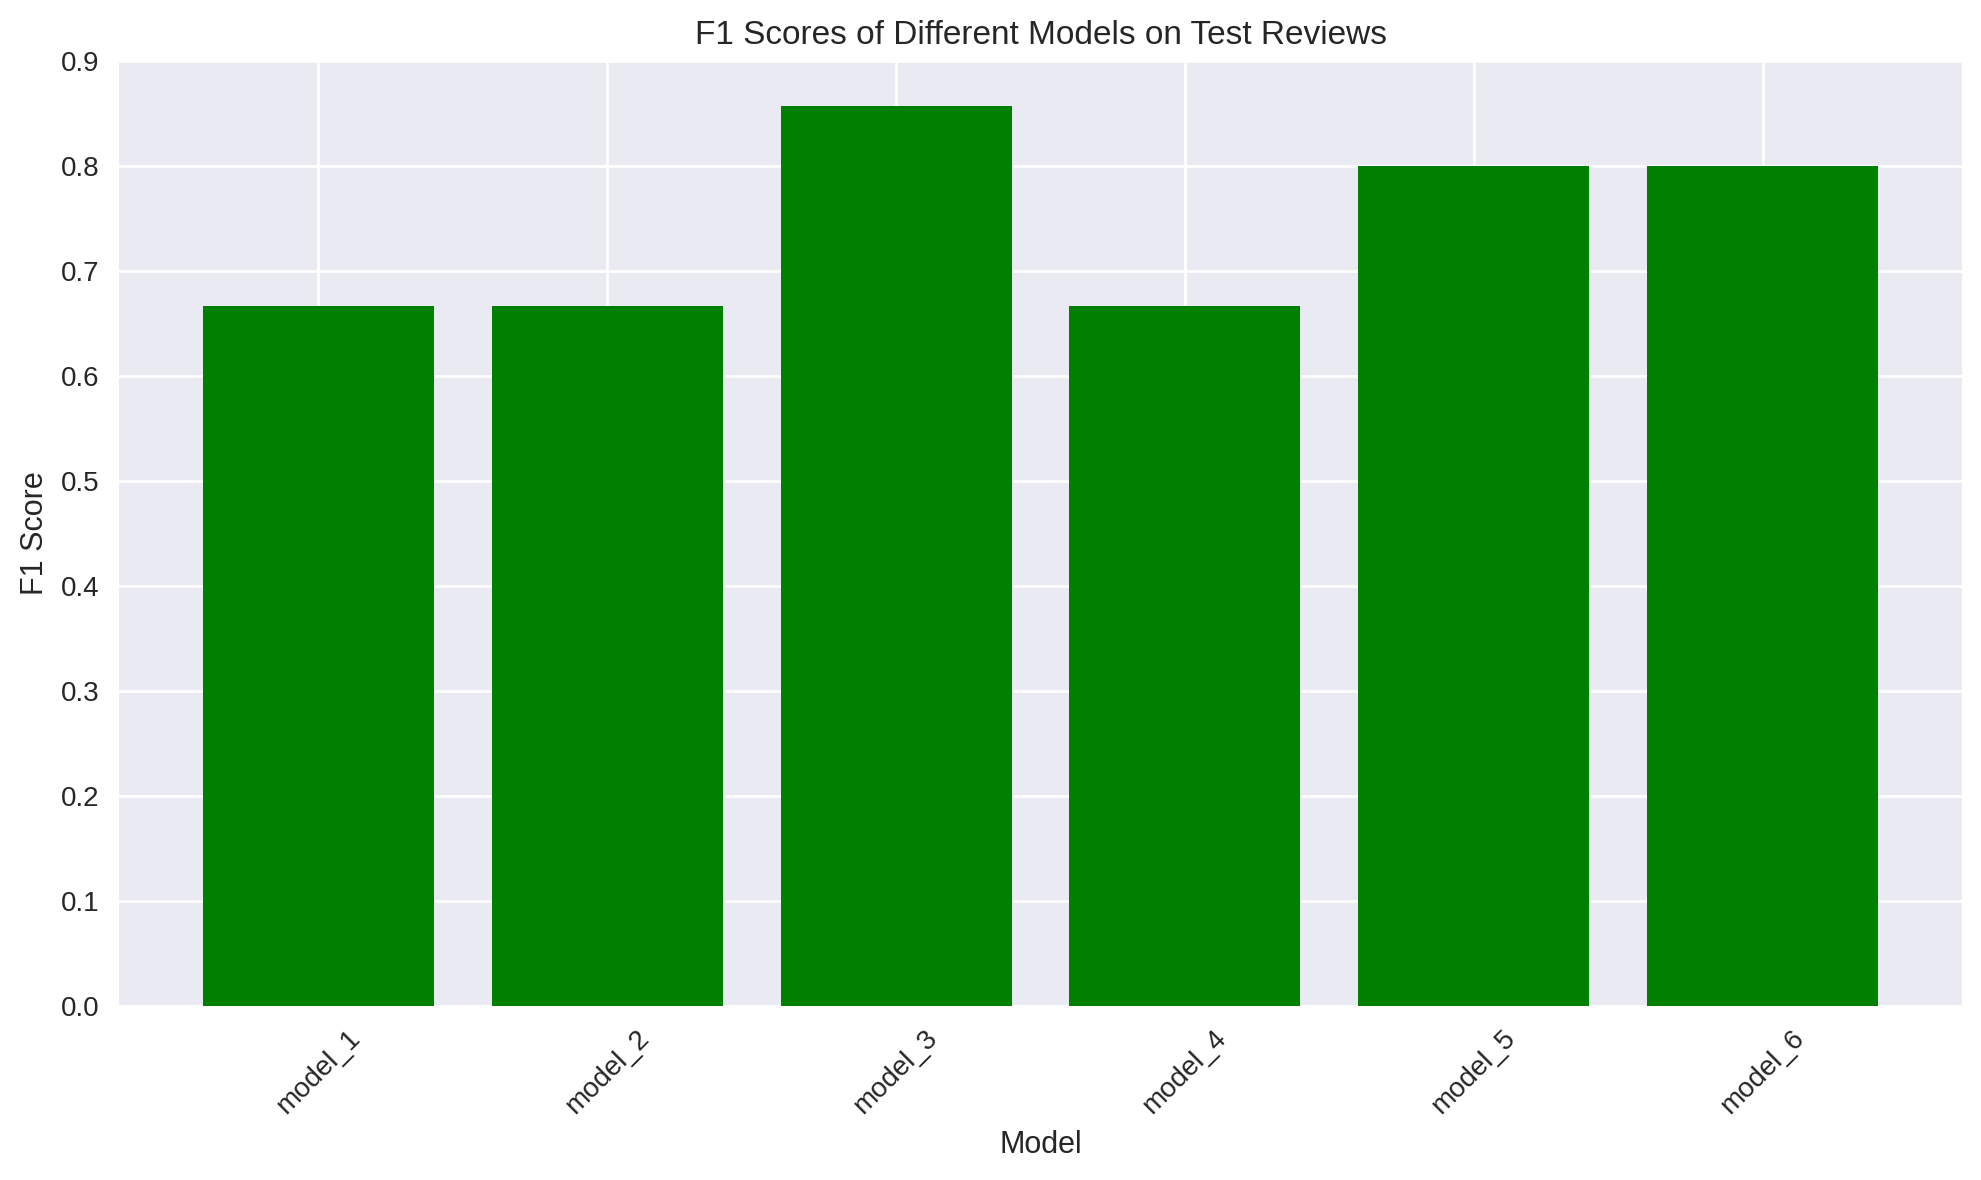

In [47]:
models = results_df['model']
scores = results_df['score_on_my_reviews']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, scores, color='green')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Models on Test Reviews')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

- Several of the models reached or exceeded the F1 threshold value of .85. In descending order, they were model_1, model_4, model_3, and model_5. Hyperparameter tuning or adding GridSearchCV to the model pipelines could result in better performing models, but there was no need for that.
- Model_1 did not perform best with the sample of my_reviews. Model_3 and model_5 performed the best as shown in the graph above. The best overall model would probably be model_3 (Bag of Words and LogisticRegression) due to its performance on the test set, the my_reviews sample, and the low level of complexity and time needed for model training.
- There was also no need to balance the classes in this case. Again, we could do that if we wanted to increase the performance, but it was not necessary to reach the threshold value. Both balancing the classes and hyperparameter tuning allow for east routes for improving model performance should there ever be a need to revisit and refine this code.
- The BERT embeddings algorithm consistently crashed this notebook so it was not included in the final product. 